# SEIR Model 
* Na Jiang (Richard)
* Agent-Based Model for Sythetic population paper use case of disease model

## Objective
* Build an ABM to simulate the spread of disease through peoples' social networks

In [1]:
import random
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx
import math
import copy

## 1, Load Data & Networks

In [2]:
#Sample Population
pop = pd.read_csv('../Map_SEIR_model/U_county_pop.csv').iloc[:,1:]#.set_index('id')
#Networks
#hhold_networks
hhold_nw = nx.read_adjlist('Data/hhold.csv', delimiter=',')
#daycare
daycare_nw = nx.read_adjlist('Data/daycare_nw.csv', delimiter=',')
#school
school_nw = nx.read_adjlist('Data/school_nw.csv', delimiter=',')
#work
work_nw = nx.read_adjlist('Data/work_nw.csv', delimiter=',')

In [5]:
pop.shape

(153253, 9)

## 2, SEIR Model

* Susceptible: all agent could be susceptible 
* Exposed: the delay of acquisition if infection and infection
* Infectious: confirmed cases
* Recovered: recover from the COVID-19
* Death: Disappear from the world

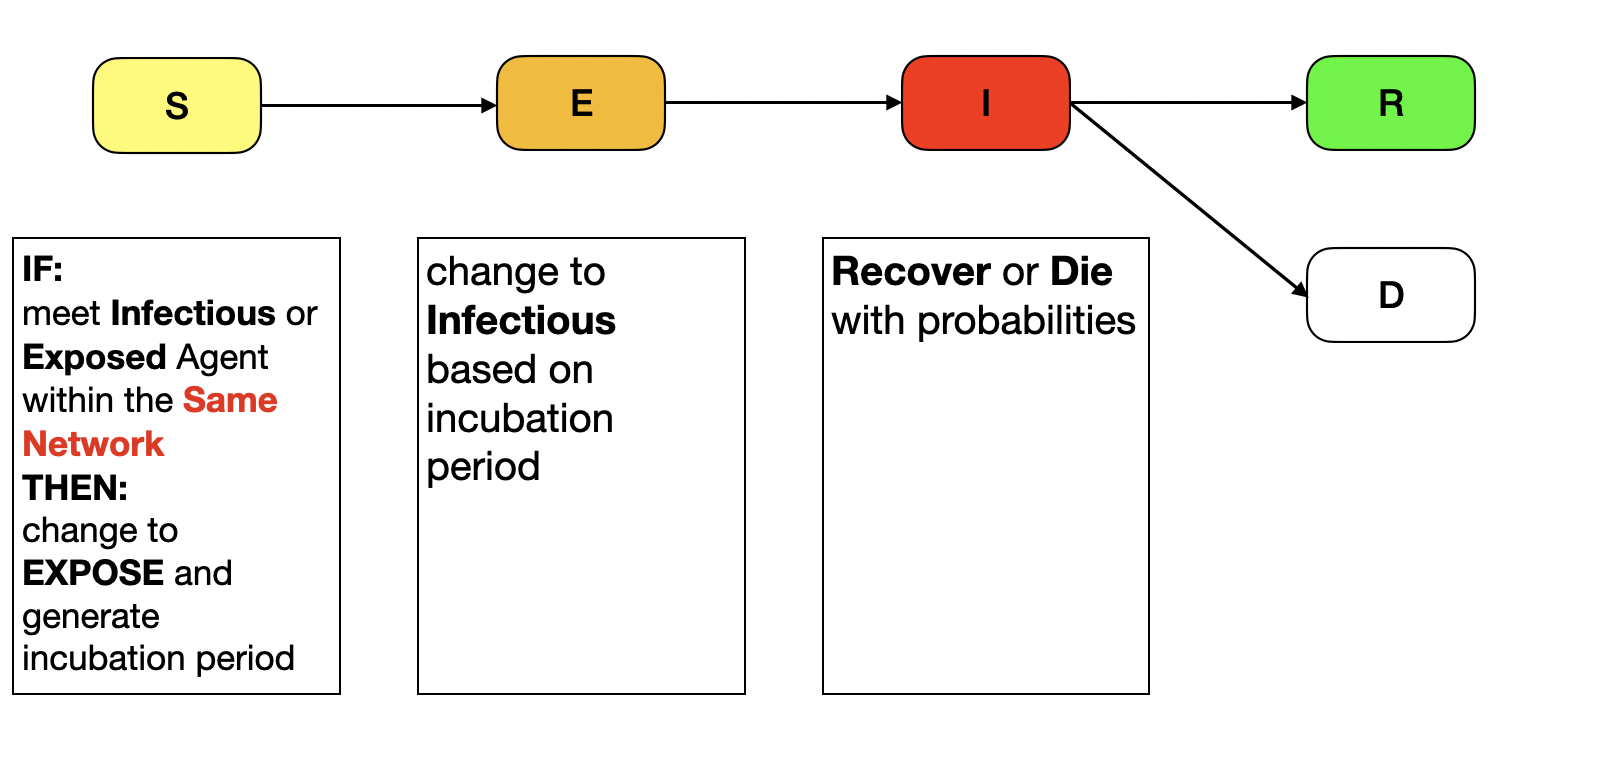

## 3, Agent-Based Model

### 3.1 Set parameter

### 3.2  Agent-Based Model, Simulation

In [7]:
#Random int generator based on normal distribution
def GenBoundedRandomNormal(meanVal, stdDev, lowerBound, upperBound):
    aRand = random.gauss(meanVal,stdDev) # could also use: normalvariate()but gauss () is slightly faster.
    
    while (aRand < lowerBound or aRand > upperBound):
        aRand = random.gauss(meanVal,stdDev)
    return aRand

In [8]:
# Agent class
class Agent(object):
    def __init__(self, World):        
        
        self.id = 0
        self.age = 0
        
        #hhold
        self.hhold_id = []
        self.hhold_size = []
        self.hhold_member = []
        #work
        self.work_id = []
        self.work_size = []
        self.work_member =[]
        
        #S, 0; E, 1; I, 2; R,3; D,4
        self.status = 0
        #incubation days
        self.incubation = 0
        self.recovery = 0
        #days track
        self.days = 0
        self.location = 0 #if infected in work set 1, if at home set 2
        self.when = 0;

In [171]:
class World(object):
    def __init__(self):
        #Number of Agnets
        self.numberOfAgent = N
        #Generate Agents list
        self.agent = [Agent(self) for i in range(self.numberOfAgent)]
    
    def Init_agents(self, pop, H, W, S, D):#population dataset, hhold network, work network, School network,, dfaycare network
        index_list = []
        id_list = []
        for i in range(self.numberOfAgent):
            index_list.append(i)
            #ID
            self.agent[i].id = str(pop.id[i])
            id_list.append(self.agent[i].id)
            #print(type(self.agent[i].id))
            #age
            self.agent[i].age = int(pop.age[i])
            
            #status
            self.agent[i].status = 0 # set healthy at the initialization
            
            #hhold
            #hhold id
            self.agent[i].hhold_id = pop.hhold[i]
            #hhold size
            self.agent[i].hhold_size = H.degree(self.agent[i].id)
            #hhold member
            self.agent[i].hhold_member = list(H.neighbors(self.agent[i].id))
            
            #work based on age and workplace ID
            self.agent[i].work_id = pop.wp[i]
            
            #Adults
            if self.agent[i].age >= 18:
                #work from home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                else:
                    #work size
                    self.agent[i].work_size = W.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(W.neighbors(self.agent[i].id))
            
            #kids go to daycare
            if self.agent[i].age <= 3:
                #stay at home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                #go to daycare
                else:
                    #daycare nw size
                    self.agent[i].work_size = D.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(D.neighbors(self.agent[i].id))
            
            #kids go to school 
            if (self.agent[i].age < 18) and (self.agent[i].age > 3):
                #daycare nw size
                self.agent[i].work_size = S.degree(self.agent[i].id)
                #work member
                self.agent[i].work_member = list(S.neighbors(self.agent[i].id))  
            
            #incubation day
            self.agent[i].incubation = int(GenBoundedRandomNormal(5, 3, 1, 15)) * 3
            
            self.agent[i].recovery = int(GenBoundedRandomNormal(7, 3, 5, 20)) * 3
            
            #print(i, "Agent ", self.agent[i].id," has", self.agent[i].hhold_size,"family menbers. Current Status", self.agent[i].status, "Incubation:", self.agent[i].incubation, "Days", self.agent[i].days)

        #set a infected agents
        id_dictionary = dict(zip(id_list, index_list))
        #random choose five agents and set them as infected
        for j in range(5):
            x = random.choice(range(N))
            self.agent[x].status = 2   #change status to infected
            self.agent[x].infected = 1 #first day infected
            print("Init_agent->The Infected Nodes is ", x, "status", self.agent[x].status)
        
        return id_dictionary

                  
    def Spread_and_Infect_Home(self, id_dict, DAY):
        #print('Home Networks Spread')
        for i in range(self.numberOfAgent):            
            #Get infected
            #if reach the incubation days, then get  infected
            if (self.agent[i].status == 1) and (self.agent[i].days == self.agent[i].incubation):
                self.agent[i].status = 2
                self.agent[i].days = 0
                self.agent[i].when = DAY #infected day

             
            #Spread the disease, infected lead agent change status to 1
            #status 1 and 2 spread the disease through the network
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):
                for j in range(self.agent[i].hhold_size): 
                    a_id = self.agent[i].hhold_member[j]
                    a_index = id_dict.get(a_id)
                    #print("id", a_id, "its index is", a_index)
                    
                    if (self.agent[a_index].status != 4): 
                        if ((self.agent[a_index].status == 0) ) and (random.random() < 0.2):
                            self.agent[a_index].status = 1
                            self.agent[a_index].days = 0
                            self.agent[a_index].location = 2 #infected at home
                            #self.agent[a_index].when = DAY #infected day
                            #print("Home: Agent get infected,", self.agent[i].status, "at location,", self.agent[a_index].location, "in Day", self.agent[a_index].when)
    
    
    def Spread_and_Infect_Work(self, id_dict, DAY):
        for i in range(self.numberOfAgent):            
            #Get infected
            #if reach the incubation days, then get  infected   
            if (self.agent[i].status == 1) and (self.agent[i].days == self.agent[i].incubation):
                self.agent[i].status = 2
                self.agent[i].days = 0
                self.agent[i].when = DAY #infected day
             
            #Spread the disease, infected lead agent change status to 1
            #status 1 and 2 spread the disease through the network
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):
                for j in range(self.agent[i].work_size): 
                    a_id = self.agent[i].work_member[j]
                    #check if the member is in the sample population
                    if a_id not in id_dict.keys():
                        print('Not')
                    else:
                        #print("in")
                        a_index = id_dict.get(a_id)
                        if (self.agent[a_index].status != 4): #and (self.agent[i].interacted > 0):
                            #if ((self.agent[a_index].status == 0) or (self.agent[a_index].status == 3)) and (random.random() < 0.2):
                            if ((self.agent[a_index].status == 0)) and (random.random() < 0.2):
                                self.agent[a_index].status = 1
                                self.agent[a_index].days = 0
                                self.agent[a_index].location = 1 #infected at work
                                
                                #print("Work: Agent get infected,", self.agent[i].status, "at location,", self.agent[a_index].location, "in Day", self.agent[a_index].when)

    
    def Recover(self):
        for i in range(self.numberOfAgent):
            if (self.agent[i].status == 2) and (self.agent[i].days == self.agent[i].recovery):
                dice = random.random()
                #print(self.agent[i].id, "Recover")
                if dice < 0.1:
                    self.agent[i].status = 4 #die
                else:
                    self.agent[i].status = 3 #revover
    
    def Recover_and_Die(self, H, W, S, D): 
        for i in range(self.numberOfAgent):
            if self.agent[i].status != 4:
                dice = random.random()
                #print(dice)
                #Recover
                if (self.agent[i].status == 2) and (dice > 0.8):
                    #print(self.agent[i].id, "Recover")
                    self.agent[i].status = 3
                    self.agent[i].location = 0
            
                #Die
                if (self.agent[i].status == 2) and (dice < 0.01):
                    #print(self.agent[i].id, "Dies")
                        self.agent[i].status = 4
                        #Adults
                        if self.agent[i].age >= 18:
                            #work from home
                            if self.agent[i].work_id == self.agent[i].hhold_id:
                                H.remove_node(self.agent[i].id)
                            else:
                                W.remove_node(self.agent[i].id)
                
                        #kids go to daycare
                        if self.agent[i].age <= 3:
                            #stay at home kids
                            if self.agent[i].work_id == self.agent[i].hhold_id:
                                H.remove_node(self.agent[i].id)
                            else:
                                D.remove_node(self.agent[i].id)
                
                        #kids go to school 
                        if (self.agent[i].age < 18) and (self.agent[i].age > 3):
                            S.remove_node(self.agent[i].id)
                      
    def Update_SEIR_List(self, DAY):
        S = []
        E = []
        I = []
        R = []
        D = []
        
        T = DAY
        for i in range(self.numberOfAgent):
            #D.append(self.agent[i].days)
            
            if self.agent[i].status == 0:
                S.append(self.agent[i].id)
            
            if self.agent[i].status == 1:
                #Update Days
                self.agent[i].days += 1
                E.append(self.agent[i].id) 
                
            if self.agent[i].status == 2:
                self.agent[i].days += 1
                I.append(self.agent[i].id)
                
            if self.agent[i].status == 3:
                R.append(self.agent[i].id)
            
            if self.agent[i].status == 4:
                D.append(self.agent[i].id)
           
        return T, len(S), len(E), len(I), len(R), len(D)
    
    def Get_Location(self, DAY):
        Home = []
        Work = []
        Daycare = []
        School  = [] 
        T = DAY
        #print(T)
        for i in range(self.numberOfAgent):
            if self.agent[i].status == 2:
                #home
                if (self.agent[i].location == 2) and (self.agent[i].when == DAY):
                    #print("Case 1")
                    Home.append(self.agent[i].id)   
                elif (self.agent[i].location == 1) and (self.agent[i].when == DAY):
                    #print("Case 2")
                    #daycare
                    if self.agent[i].age <= 2:
                        #print("Case 2.1")
                        Daycare.append(self.agent[i].id)
                    #school
                    if (self.agent[i].age <= 17) and (self.agent[i].age >= 3): 
                        #print("Case 2.2")
                        School.append(self.agent[i].id)
                    #work
                    if self.agent[i].age >= 18:
                        #print("Case 2.3")
                        Work.append(self.agent[i].id)                
        
        return T, len(Home), len(Work), len(Daycare), len(School)
        

In [191]:
def plot_SEIR(df):
        #self.df = pd.DataFrame(Results, columns=['S', 'E', 'I', 'R', 'D'])
    print(df.head())
        
    plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
        
    #plt.plot
    plt.plot(df.index, df.S, marker='o', markerfacecolor='gray', markersize=2, color='skyblue', linewidth=2)
    plt.plot(df.index, df.E, marker='o', markerfacecolor='gray', markersize=2, color='yellow', linewidth=2)
    plt.plot(df.index, df.I, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, df.R, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    plt.plot(df.index, df.D, marker='o', markerfacecolor='gray', markersize=2, color='black', linewidth=2)
        
    plt.legend(('Susceptible', 'Exposed', 'Infectious','Recovered', 'Dead'), prop={"size":20},
               fancybox=True, framealpha=1, shadow=True,loc = 'upper right', ncol = 5)
        
    plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
    #plt.grid(linestyle=':')   # 显示网格
        
    plt.savefig('SEIR_WL.png')

## 4 Simulation Results and Analysis

### 4.1 WS1 

In [179]:
class Sim(object):
    def __init__(self):
        self.World = World()
        self.df = pd.DataFrame([])
       
    def Run(self, H, W, S, D, DAYS):
        steps = DAYS * 3
        print("Simulation steps:", steps)
        
        id_d = self.World.Init_agents(pop, H, W, S, D) 
        #print(type(id_d))
        #print(id_d)
        
        Results = []
        Location = []

        day = 0
        for i in range(0,steps):
            if i % 3 == 0:
                #SEIR
                t, x1, x2, x3, x4, x5 = self.World.Update_SEIR_List(day)
                Results.append([t, x1, x2, x3, x4, x5])
                
                #Location
                time, h, w, d, s = self.World.Get_Location(day)
                Location.append([time, h, w, d, s])
                
                if day % 10 == 0:
                    print("Current Day: ", day)
                day = day + 1

            if (i % 3 == 0):
                #print("Day:", day,"Moring")
                self.World.Spread_and_Infect_Home(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])
    
            if i % 3 == 1:
                #print("Day:", day,"Daytime")
                self.World.Spread_and_Infect_Work(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])
        
            if i % 3 == 2:
                #print("Day:", day,"Evening")
                self.World.Spread_and_Infect_Home(id_d, day)
                self.World.Recover()
                #time, h, w, d, s = self.World.Get_Location(day)
                #Location.append([time, h, w, d, s])            
     
        #SEIR
        df1 =  pd.DataFrame(Results, columns=['Day','S', 'E', 'I', 'R', 'D']) 
        #Location
        df2 = pd.DataFrame(Location, columns=['Day','Home', 'Work', 'Daycare', 'School'])
        return df1, df2

In [180]:
# Number of agents
N = len(pop)
print("Population size", N)
#Number of Days
DAYS = 60
print("Simulation of ", DAYS, "days")

if __name__ == '__main__':
    aSim = Sim()
    print ("simulation starts...")
    #Network
    H = deepcopy(hhold_nw)
    W = deepcopy(work_nw)
    S = deepcopy(school_nw)
    D = deepcopy(daycare_nw)
    SEIR, Loc = aSim.Run(H, W, S, D, DAYS)
    print("Done~")

Population size 153253
Simulation of  60 days
simulation starts...
Simulation steps: 180
Init_agent->The Infected Nodes is  142533 status 2
Init_agent->The Infected Nodes is  125099 status 2
Init_agent->The Infected Nodes is  56435 status 2
Init_agent->The Infected Nodes is  80190 status 2
Init_agent->The Infected Nodes is  53024 status 2
Current Day:  0
Current Day:  10
Current Day:  20
Current Day:  30
Current Day:  40
Current Day:  50
Done~


   Day       S    E  I  R  D
0    0  153248    0  5  0  0
1    1  153236   12  5  0  0
2    2  153222   26  5  0  0
3    3  153164   84  5  0  0
4    4  153000  248  5  0  0


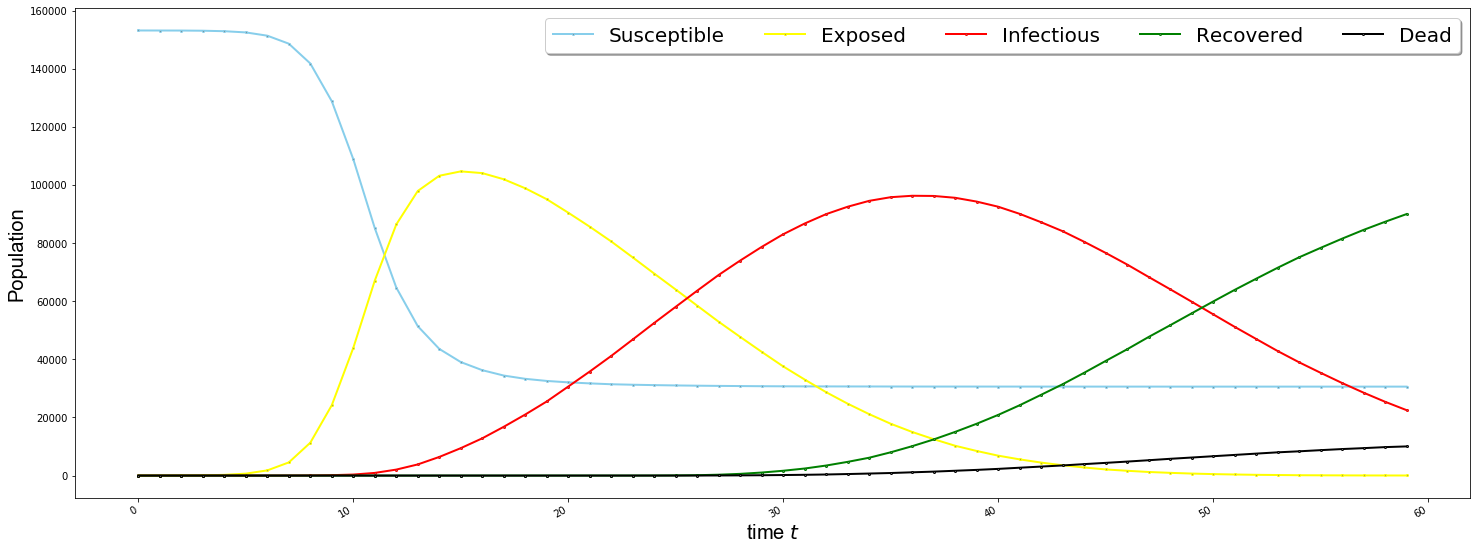

In [192]:
plot_SEIR(SEIR)

In [193]:
def plot_Loc(df):
    print(df.head())
        
    plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    
    #extract data
    temp1 = list(df.Home)
    temp2 = list(df.Work)
    temp3 = list(df.Daycare)
    temp4 = list(df.School)
    
    #New list to plot
    home = []
    work = []
    daycare = []
    school  = []
    
    for i in range(len(temp1)):
        if i == 0:
            home.append(temp1[i])
            work.append(temp2[i])
            daycare.append(temp3[i])
            school.append(temp4[i])
        if i != 0:
            h = home[i - 1] + temp1[i]
            w = work[i - 1] + temp2[i]
            d = daycare[i - 1] + temp3[i]
            s = school[i - 1] + temp4[i]
        
            home.append(h)
            work.append(w)
            daycare.append(d)
            school.append(s)
        
    #plt.plot
    plt.plot(df.index, home, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    plt.plot(df.index, work, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, daycare, marker='o', markerfacecolor='gray', markersize=2, color='orange', linewidth=2)
    plt.plot(df.index, school, marker='o', markerfacecolor='gray', markersize=2, color='blue', linewidth=2)
        
    plt.legend(('Home', 'Work', 'Daycare','School'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper left', ncol = 4)
        
    plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
    #plt.grid(linestyle=':')   # 显示网格
        
    plt.savefig('Home_Work_Infected_wL.png')

   Day  Home  Work  Daycare  School
0    0     0     0        0       0
1    1     0     0        0       0
2    2     0     0        0       0
3    3     0     0        0       0
4    4     0     0        0       0


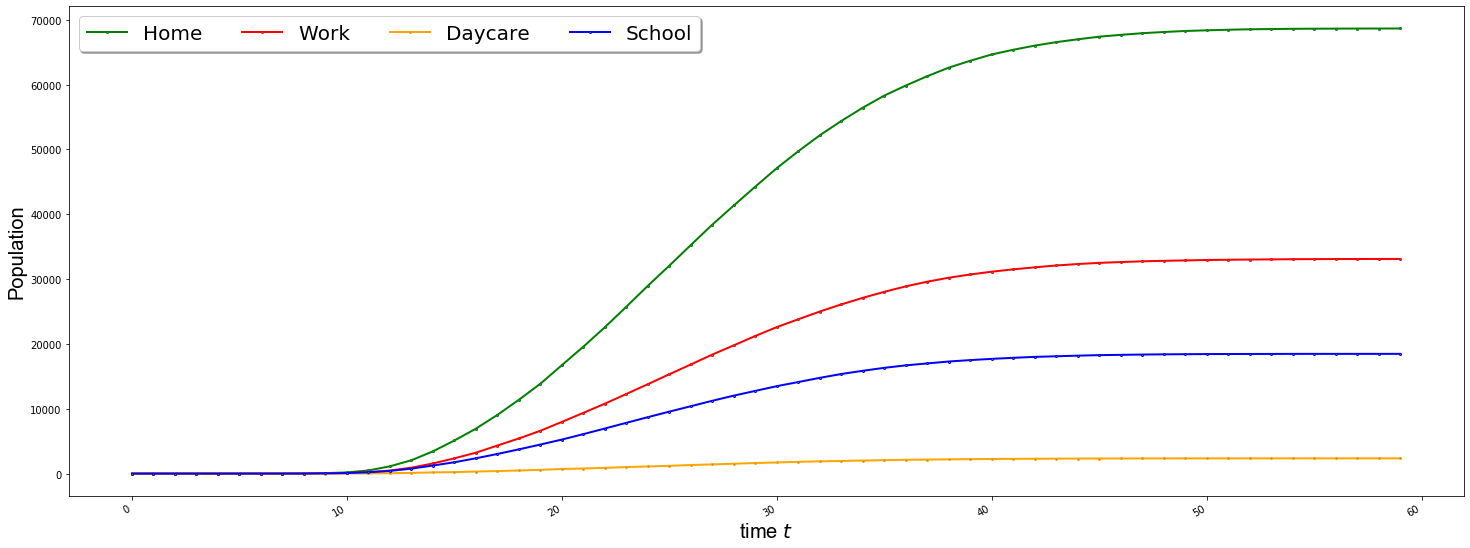

In [194]:
plot_Loc(Loc)